In [8]:
lcs = pd.read_csv(r'C:\Users\tyler\twitch-chat-log-downloader\lcswk3d3.csv')
lcs

,VOD timestamp,Message time,Username,Twitch ID,Message,Account create date
0,00:00:06,2021-02-21 19:33:21,baddog86,198015559,first,2018-02-23 21:28:21
1,00:00:14,2021-02-21 19:33:29,bogusjedi,57357437,Dig won?,2014-02-21 17:16:28
2,00:00:15,2021-02-21 19:33:30,lickeroffaces,225673101,last,2018-05-24 11:44:41
3,00:00:16,2021-02-21 19:33:31,haterofppl,27939766,not really,2012-02-03 17:36:11
4,00:00:20,2021-02-21 19:33:34,bogusjedi,57357437,Weird champ.,2014-02-21 17:16:28
...,...,...,...,...,...,...
39631,04:36:22,2021-02-22 00:09:36,linthros,69318530,TIMER STOPPED KEKW,2014-08-18 13:56:22
39632,04:36:22,2021-02-22 00:09:37,zeoridian,124610350,timer,2016-05-19 10:44:05
39633,04:36:22,2021-02-22 00:09:37,caralhudogz,465539566,pls end pls,2019-10-05 12:31:12
39634,04:36:22,2021-02-22 00:09:37,xetfrick8,450072564,51minutes KEKW,2019-07-23 02:24:42


In [13]:
# Adding text-length as a field in the dataset
lcs['text length'] = lcs['Message'].apply(len)
print(lcs.head())

TypeError: object of type 'float' has no len()

In [14]:
type(lcs['Message'])

pandas.core.series.Series

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [23]:
message = lcs.Message
message = message.astype(str)

In [25]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
# other_exclusions = ["#ff", "ff", "rt"]
# stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(message):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    message_space = message.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    message_name = message_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    messages = message_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = messages.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newmsg =punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newmsg = newmsg.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newmsg = newmsg.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    msg_lower = newmsg.str.lower()
    
    # tokenizing
    tokenized_msg = msg_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_msg =  tokenized_msg.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_msg = tokenized_msg.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_msg)):
        tokenized_msg[i] = ' '.join(tokenized_msg[i])
        msgs_p= tokenized_msg
    
    return msgs_p

processed_msgs = preprocess(message)   

lcs['processed_msgs'] = processed_msgs
print(lcs[["Message","processed_msgs"]].head(10))

                                             Message  \
0                                              first   
1                                           Dig won?   
2                                               last   
3                                         not really   
4                                       Weird champ.   
5  @LCS Thank you :) I appreciate the mods of thi...   
6                                                 xd   
7                                   any vod viewers?   
8           Just here early to watch some ads Pepega   
9                                           Haha2020   

              processed_msgs  
0                      first  
1                        dig  
2                       last  
3                     realli  
4                weird champ  
5  thank appreci mod channel  
6                         xd  
7                 vod viewer  
8      earli watch ad pepega  
9                       haha  


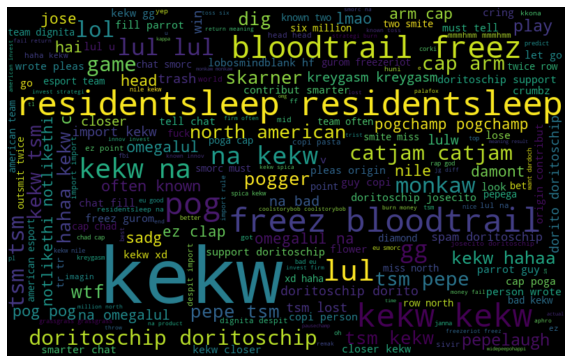

In [26]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in lcs['processed_msgs'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [28]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(lcs['processed_msgs'] )
tfidf

<39636x3574 sparse matrix of type '<class 'numpy.float64'>'
	with 119816 stored elements in Compressed Sparse Row format>

In [30]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...


True

In [31]:
sentiment_analyzer = VS()
def count_tags(message_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', message_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(message):   
    sentiment = sentiment_analyzer.polarity_scores(message)    
    twitch_objs = count_tags(message)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitch_objs[0], twitch_objs[1],
                twitch_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(messages):
    features=[]
    for t in messages:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(message)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
1,0.000,0.787,0.213,0.5719,0.0,0.0,0.0
2,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
3,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
4,0.354,0.646,0.000,0.3400,0.0,0.0,0.0
...,...,...,...,...,...,...,...
39631,0.487,0.000,0.513,-0.2263,0.0,0.0,0.0
39632,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
39633,0.000,0.722,0.278,0.1531,0.0,0.0,0.0
39634,0.000,0.000,1.000,0.0000,0.0,0.0,0.0


In [32]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(39636, 3581)

need linguistic tagged dataset
    yelp dataset ?
    https://monkeylearn.com/sentiment-analysis/
    geometry type nlp
    1. find emoticon dictionaries
    2. how many are in my data
    3. how many do we have in data but not in dictionary
        how many pos and how many negatives~
        words seem to be straight forward and to the point
        (no linguistic subtlety)
        use emotes to code sentiment ->